# Q5 Assumed Density Filtering
### Q5.1 Pre-processing and variables

In [23]:
# Q5 Assumed density filtering
# import preprocessing function and Gibbs sampler function
from Preprocessing_serieA_function import preprocess_serieA_no_draws
from Gibbs_sampler_function import gibbs_sampling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# load data
data = pd.read_csv('SerieA_dataset.csv')

# preprocess data
data_preprocessed = preprocess_serieA_no_draws(data)
print(data_preprocessed.head())
# Create team dictionary test 1
unique_teams_1 = data_preprocessed['team1'].unique().tolist()
mean=[25 for i in range(len(unique_teams_1))]
variance=[64 for i in range(len(unique_teams_1))]

teams_dictionary = {i:[25,64] for i in unique_teams_1}

# Create team dictionary test 2 for shuffled data
shuffled_teams_dictionary = {i:[25,64] for i in unique_teams_1}

# shuffle data
shuffled_data = data_preprocessed.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)
print(shuffled_data.head())

# print(teams_dictionary)

game1 = data_preprocessed.iloc[0, :]
# print(game1[0])
# print(f'\nFirst game:\n {game1}')

      team1     team2  y
0    Chievo  Juventus -1
1     Lazio    Napoli -1
2    Torino      Roma -1
3  Sassuolo     Inter  1
5    Empoli  Cagliari  1
     team1     team2  y
0   Torino     Inter  1
1  Udinese  Atalanta -1
2     Spal  Sassuolo -1
3   Empoli    Torino  1
4   Empoli  Sassuolo  1


# Q.6
### Q6.1 prediction function

In [ ]:
predictions = []
# Prediction function (deterministic)
# if skills are equal, team 1 wins, might need to change this
def prediction(team1_mean, team2_mean):
    if team1_mean > team2_mean:
        return 1
    elif team1_mean < team2_mean:
        return -1
    elif team1_mean == team2_mean:
        return 1
    else:
        print('Error in prediction function')


### Q5.2 Assumed Density Filtering (ADF) function

In [ ]:
# Assumed density filtering (ADF)
def ADF(teams_dictionary, dataframe):
    # print(dataframe.head())
    # print(teams_dictionary)

    # Assumed density filtering (ADF)
    n_iter = 2000
    # Loop over all games

    for index, game1 in dataframe.iterrows():
        
        # Load means and variances from dictionary
        mean_team1 = float(teams_dictionary[game1[0]][0])
        mean_team2 = float(teams_dictionary[game1[1]][0])

        variance_team1 = float(teams_dictionary[game1[0]][1])
        variance_team2 = float(teams_dictionary[game1[1]][1])

        # One-Step-Ahead prediction
        y_pred = prediction(mean_team1, mean_team2)
        predictions.append(y_pred)
        
        # create mean column and covariance matrix
        s1_s2_mean_col = np.array([[mean_team1, mean_team2]]).reshape(-1,1)
        s_cov_matrix = np.array([[variance_team1, 0], [0, variance_team2]])

        y = game1['y']


        s1_means, s2_means, s1_vars, s2_vars, s1_samples, s2_samples = gibbs_sampling(n_iter, s1_s2_mean_col, s_cov_matrix, y)

        # print(f'\nMean of team 1: {s1_means[-1]}')
        # print(f'\nMean of team 2: {s2_means[-1]}')

        # Update team dictionary means
        teams_dictionary[game1[0]][0] = s1_means[-1]
        teams_dictionary[game1[1]][0] = s2_means[-1]

        # update team dictionary variances
        teams_dictionary[game1[0]][1] = s1_vars[-1]
        teams_dictionary[game1[1]][1] = s2_vars[-1]

    return teams_dictionary

## Q5 & Q6: Run functions

In [ ]:
# Run ADF on data
dic1= ADF(teams_dictionary, data_preprocessed)

# Run ADP on shuffled data
# dic_shuffled = ADF(shuffled_teams_dictionary, shuffled_data)

# Results:
### Team ranking changes after shuffle
#### prediction rate of one-step-head = 0.64, better than random guessing(0.5)

In [27]:
# Create dataframe of means and variances
teams_df = pd.DataFrame(dic1, index=['mean', 'variance']).T
teams_df = teams_df.sort_values(by=['mean'], ascending=False)
print('Teams after the season, no shuffle:')
print(teams_df)

# Calculate prediction rate
from sklearn.metrics import accuracy_score
y_true = data_preprocessed['y'].tolist()
prediction_rate = accuracy_score(y_true, predictions)
print(f'\nPrediction rate of One-Step-Ahead prediction: {prediction_rate}')

# prediction rate of last 60 games
y_true_last_60 = y_true[-10:]
predictions_last_60 = predictions[-10:]
prediction_rate_last_60 = accuracy_score(y_true_last_60, predictions_last_60)
print(f'\nPrediction rate of One-Step-Ahead prediction for last 60 games: {prediction_rate_last_60}')



# create dataframe of shuffled means and variances
# teams_df_shuffled = pd.DataFrame(dic_shuffled, index=['mean', 'variance']).T
# teams_df_shuffled = teams_df_shuffled.sort_values(by=['mean'], ascending=False)
# print('\nTeams after the season, with shuffle:')
# print(teams_df_shuffled)


Teams after the season, no shuffle:
                 mean  variance
Juventus    36.482010  0.000216
Napoli      29.369931  0.000210
Torino      26.271370  0.000243
Roma        26.036053  0.000237
Genoa       25.161622  0.000311
Milan       25.113930  0.000204
Atalanta    24.782000  0.000231
Sampdoria   24.637599  0.000193
Inter       24.585426  0.000233
Spal        24.556108  0.000201
Empoli      23.471590  0.000195
Sassuolo    23.072610  0.000302
Lazio       22.725028  0.000199
Fiorentina  22.667780  0.000298
Bologna     22.548931  0.000201
Parma       22.461052  0.000271
Cagliari    21.950213  0.000194
Udinese     21.337049  0.000208
Frosinone   19.485199  0.000204
Chievo      15.772741  0.000253

Prediction rate of One-Step-Ahead prediction: 0.6397058823529411

Prediction rate of One-Step-Ahead prediction for last 60 games: 0.7


mean of team 1: 15.931529795621724
variance of team 1: 0.0014074318944179067


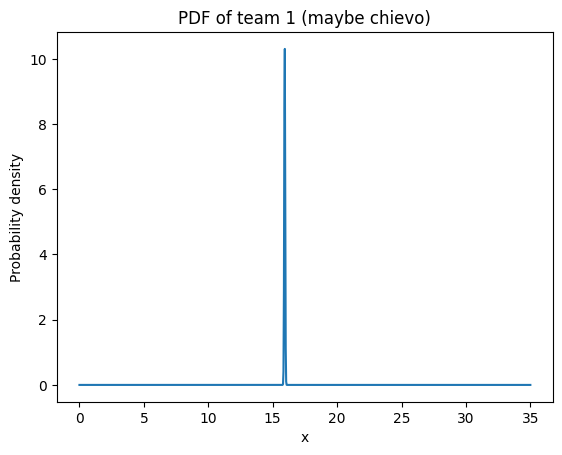

In [20]:
# Plot the pdf of one of the teams
means_of_dic1 = [i[0] for i in teams_dictionary.values()]
variances_of_dic1 = [i[1] for i in teams_dictionary.values()]

x = np.linspace(0, 35, 1000)
y = stats.norm.pdf(x, means_of_dic1[0], np.sqrt(variances_of_dic1[0]))
print(f'mean of team 1: {means_of_dic1[0]}')
print(f'variance of team 1: {variances_of_dic1[0]}')

plt.plot(x, y)
plt.title('PDF of team 1 (maybe chievo)')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.show()
